### Exercice Concret Intégrant une API

#### **Scénario Global**
Le candidat doit utiliser une API publique pour récupérer des données, nettoyer et transformer ces données, puis les analyser et les visualiser. Le candidat peut utiliser une API de son choix, comme l'API de météo (OpenWeatherMap), l'API de films (OMDb), ou toute autre API publique.

#### **Étapes du Test**

1. **Récupération des Données**
   - **Tâche :** Utiliser une API publique pour récupérer des données.
   - **Scénario possible :** Utiliser l'API OpenWeatherMap pour récupérer les données météorologiques de la semaine dernière pour une ville spécifique.

2. **Nettoyage et Transformation des Données**
   - **Tâche :** Nettoyer et transformer les données récupérées pour une analyse ultérieure.
   - **Scénario possible :** Extraire les températures quotidiennes et les dates des données récupérées.

3. **Analyse des Données**
   - **Tâche :** Analyser les données pour extraire des insights.
   - **Scénario possible :** Calculer la température moyenne de la semaine.

4. **Visualisation des Données**
   - **Tâche :** Créer des visualisations des données pour les présenter de manière claire.
   - **Scénario possible :** Créer un graphique montrant l'évolution des températures au cours de la semaine.
  
5. **Documentation et Explications**
   - **Tâche :** Documenter le code et expliquer les choix faits.
   - **Contrainte :** Le candidat doit ajouter des commentaires dans le code et fournir une explication de chaque étape.

### Résumé des Compétences Évaluées
- **Utilisation des API :** Compréhension des requêtes HTTP et des formats de données (JSON).
- **Nettoyage des Données :** Transformer les données avec utilisation de librairie python dédié.
- **Analyse des Données :** Calcul de métriques simples et extraction d'insights.
- **Visualisation des Données :** Créer des graphiques avec utilisation de librairie python.
- **Documentation et Communication :** Clarté du code et capacité à expliquer les processus.

# Goals

My goal on this test is to provide insights on the watching habits of users during different time seasons
To  make this happend  we will make the following protocole
- Choose an API wich gather informations about the views of a film according to a specific periode of time, and specific information about the user such as movies preferencie and others
- Explore the data and build a coherent dataset
- Get some insight numbers first of all to present the data second correlated to the task
- Present the result in a comprehensive and insight full way

  We will create an ETL pipe line
  - Extract data from API
  - Transform data
  - Load in CSV

# Choose the API

I chose the Trackt API,
The TrackT API is a service that follows what the users are viewing

Url  documentation: https://trakt.docs.apiary.io/

### Intersting metrics:
- Number of unique users
- Views by locations
- Views by genre
- Views by seasons
- Genre views by seasons

### /!\ vocabulary
In the context of our code variables please take in account the following vocabulary
- slug: The slug is a URL safe and globally unique version of the username
- show : A serie
- film : A film
- movie : films and shows|


# SETTINGS

In [1]:
# Main imports
import requests
import pandas as pd
from io import StringIO
from tqdm import tqdm
import time
from datetime import datetime as dt
import matplotlib.pyplot as plt

c:\Users\Lounkokobi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Pandas configuration
pd.set_option('display.max_rows',200)
tqdm.pandas()


In [3]:
# Connection configurations
config = {'API_KEY_OMDB' : '3c30a8ac',
          'CLIENT_ID_TRAKT' : 'bc1992454ebaf7ceaf602156cd79949e8459efd25197194d3b7fea2c21ca6d5a',
          'CLIENT_SECRET' :'107005382427249c54fe788ffe8851b9e9fa35037c57a286caa057f0a8452db5',
          'CODE_TRACKT' : 'AA506729',
          'API_VERSION' : '2'}

# DATA EXTRACTION

Get all the data needed to build The dataset
The API doest not gives us the hablity to get the informations we want directly
So the idea is to extract data related to other:

Steps to extract our data:

- 1 - Extract shows
- 2 - From shows extract related shows (to get a large amout of shows)
- 3 - Extract comments form shows
- 4 - Extract users from comments
- 5 - Extract watched movies from users with a batch size system to custom the amount of data extracted
- 6 - Extract genre from watched movies. This step longest of the process it depends on the amount of film/shows extracted 

In [4]:
# Server exception handling

# This variable count the maximum retries in ase of critical error
COUNT_CRITICAL = 3

# Server exception decorator
def request_exception(func):
    """
    This decorator is reponsible for manage Requests exception 
    """
    def wrapper(*args, **kwargs):
        global COUNT_CRITICAL
        try:
            return func(*args, **kwargs)
        except requests.exceptions.Timeout:
        # handling Time out errors from server
            print("Time out error")
            return None
        except requests.exceptions.TooManyRedirects:
        # handling too many redirects errors from server
            print("Too many redirects")
            return None
        except requests.exceptions.RequestException as e:
        # handling critical errors from server
            if COUNT_CRITICAL > 0:
                print("/!\ Critcal Error wait 32s before relaunch the task ")
                print("we will try to attemp three times and stop the process if the error percist ")
                print("")
                print("=> Waiting 32 seconds... attempts left", COUNT_CRITICAL)
                # wait 32s before relaunche the server (see API doc)
                time.sleep(32)
                COUNT_CRITICAL -= 1
                return None
            else:
                print("Critcal Error process stopped")
                raise SystemExit(e)
    return wrapper

In [5]:
class ExtractDataMethods():
    """
    This class offers methods to extract data from the TraktAPI

    Attributs:
        headers (Dict): Header http requests config parameters
    """
    def __init__(self, config):
        self.__headers = {"Content-Type":"application/json",
                  "trakt-api-version":config['API_VERSION'],
                  "trakt-api-key": config['CLIENT_ID_TRAKT']}
        
    @request_exception
    def related_shows(self, slug):
        """
        In order to increase number of shows we get the 
        list of shows related slug

        Args:
            slug (String):Show id
        Returns:
            A dataframe of Show's slugs
        """
        # API call
        response = requests.get("https://api.trakt.tv/shows/"+ slug + "/related", headers=self.__headers,)
        code = response.status_code
        if code == 200:
        # If the request is successfull we convert into a dataframe
            df = pd.read_json(StringIO(response.text))
            if len(df) > 0:
                # If the dataframe is not empty we access some json data of the dataframe and return it on slug column
                return pd.json_normalize(df['ids'])['slug']           
            else:
            # Else we return an empty data frame
                return pd.DataFrame(dtype="object")
        else:
            # Else we print the corresponding http error with the code
            print('Error : http status code', code ,'Failed to extract related Shows')
            # And we return an empty data frame   
            return pd.DataFrame(dtype="object")

    @request_exception
    def user_info(self, slug):
        """
        Extract a user info by slug

        Args:
            slug: Slug of the user
        Returns:
            user info dataframe
        """
        # Setting up the url parameters for the request 
        params = {"extended":"full"}
        # API call
        response = requests.get("https://api.trakt.tv/users/"+ slug, headers=self.__headers, params=params)
        code = response.status_code
        if code == 200:
        # If the request is successfull we convert into a dataframe and return it
            df = pd.read_json(StringIO(response.text))
            if len(df) > 0:
            # If the dataframe is not empty we access some json data of the dataframe and return it
                return pd.read_json(StringIO(response.text))
            else:
            # Else we return an empty data frame
                return pd.DataFrame(dtype="object")    
        else:
            # Else we print the corresponding http error with the code
            print('Error : http status code', code ,'Failed to extract user info')
            # And we return an empty data frame   
            return pd.DataFrame(dtype="object")
        
    @request_exception
    def movies_genre(self, imdbID):
        """
        Extract movies genres

        Args:
            imdbID: id movies or show
        Returns:
            film genre list or unknown
        """
        # Setting up the url parameters for the request 
        params = {"extended":"full"}
        # API call
        response = requests.get("https://api.trakt.tv/shows/" + imdbID, headers=self.__headers, params=params)
        code = response.status_code
        if code == 200:
        # If the request is successfull we return the json attribut genres
            return response.json()['genres']
        else:
            # Else we try the same request on films
            response = requests.get("https://api.trakt.tv/movies/" + imdbID, headers=self.__headers, params=params)
            code = response.status_code
            if code == 200:
            # If the request is successfull we return the json attribut genres
                return response.json()['genres']
            else:
            # Else we return the string unknown
                return 'unknown'

    @request_exception       
    def watched_movies_user(self, user_slug):
        """
        Get the list of movies watched by a user

        Args:
            user_slug: User id
        Returns:
            A dataframe with watched film/shows by a user
        """
        # API call
        response = requests.get("https://api.trakt.tv/users/" +user_slug +"/watched/movies", headers=self.__headers,)
        code = response.status_code
        if code == 200:
        # If the request is successfull we store the dataframe and return it
            df = pd.read_json(StringIO(response.text))
            if len(df) > 0:
                # add user information in the dataframe
                user_info = self.user_info(user_slug)
                age = user_info['age']['slug']
                location = user_info['location']['slug']
                df.insert(0,'age', age)
                df.insert(0,'location', location)
                df.insert(0,'id_user', user_slug)
                return df
            else:
            # Else we return an empty data frame
                return pd.DataFrame(dtype="object")
        else:
            if code != 404 and code != 401:
                print('Error : http status code', code ,'Failed to extract comments Shows slug:', user_slug)            
            return pd.DataFrame(dtype="object")

    @request_exception
    def shows_comments(self, slug):
        """
        In order to get users we need to search inside
        the shows comments ang get the public users related
        
        Args:
            slug(string):Shows id
        Returns:
            dataframe: User's slugs
        """
        # API call
        response = requests.get("https://api.trakt.tv/shows/"+ slug +"/comments/", headers=self.__headers)
        code = response.status_code
        if code == 200:
        # If the request is successfull we store the dataframe and return the needed column 
            df = pd.read_json(StringIO(response.text))
            if len(df) > 0:
                df = pd.json_normalize(df['user'], max_level=0)
                df = pd.json_normalize(df['ids'], max_level=0)
                
                return df['slug']
            else:
                # Else we return an empty data frame
                return pd.DataFrame(dtype="object")
        else:
            # Else we print the corresponding http error with the code and return an empty dataframe
            print('Error : http status code', code ,'Failed to extract comments Shows')            
            return pd.DataFrame(dtype="object")

In [6]:
class TraktExtractData():
    """
    This class extract and concat results of extraction
    to get decent amount of data

    Attributs:
        shows (DataFrame): Dataframe containing the shows
        users (DataFrame): Dataframe containing users
        watched (DataFrame): Dataframe containing watched_film by users
        genres (DataFrame): Dict containg genres related to exctracted movies
        headers (dict): Header http requests config parameters
    """
    def __init__(self, config):
        """
        Init the Trakt Extraction class attributs
        Args:
            config(dic): Dict containing settings to connect to the API            
        """
        self.config = config 
        self._shows = pd.DataFrame(dtype="object")
        self._users = pd.DataFrame(dtype="object")
        self._watched = pd.DataFrame(dtype="object")
        self._genres = {}
        self.__headers = {"Content-Type":"application/json",
                          "trakt-api-version":config['API_VERSION'],
                          "trakt-api-key": config['CLIENT_ID_TRAKT']}
        
        self.__methods = ExtractDataMethods(config)
        
    @request_exception
    def extract_shows(self, related=1, period='all'):
        """
        Extract shows and related shows 
        Args:
            period (string): String Period of time for searching most played shows
                - weakly : Most played of the week
                - all : Most played of all time
                - monthly : Most player of the month
            related (int): Number of times searching for related shows
                for each films already extracted
        """
        print("=> Shows extraction :")
        # API call
        response = requests.get("https://api.trakt.tv/shows/played/", headers=self.__headers,)
        code = response.status_code
        if code == 200:
            # If request is Ok we get the slugs of the extracted shows
            df = pd.read_json(StringIO(response.text))
            df = pd.json_normalize(df['show'],max_level=0)
            df = pd.json_normalize(df['ids'],max_level=0)
            self._shows = pd.concat([self._shows, df['slug']])
            for rel in range(related):
            # We iterate over the list of slugs to extract related shows and concat them
                print('Get releated for each shows already extracted level: ', rel+1)
                print(self._shows.columns)
                for slug in tqdm(self._shows['slug']):
                     self._shows = pd.concat([self._shows, self.__methods.related_shows(slug)])
                    
            # We drop duplicates entries to get a clean list of shows
            self._shows = self._shows.drop_duplicates()
            self._shows = self._shows.reset_index(drop=True)
            print('Success : ', len(self._shows) ,'shows extracted')
        else:
            # Else we print the corresponding http error with the code 
            print('Error : http status code', code ,'Failed to extract Most played Shows')

    @request_exception
    def extract_users(self):
        """
        Extract comments form shows and users from comments
        Args:
            period (string): Period of time for searching most played shows
                - weakly : Most played of the week
                - all : Most played of all time
                - monthly : Most player of the month
            related (int): Number of times searching for related shows
                for each films already extracted
        """
        print("=> User extraction :")
        if len(self._shows) > 0:
        # If shows had been extracted we iterate over the list of slugs to extract related comments and get users
            for slug in tqdm(self._shows['slug']):
                self._users = pd.concat([self._users, self.__methods.shows_comments(slug)])
                
            # We drop duplicates users to get a clean list
            self._users = self._users.drop_duplicates()
            self._users = self._users.reset_index(drop=True)
            print('Success : ', len(self._users) ,'users extracted')

        else:
            # Else we print the corresponding http error with the code 
            raise Exception('Exctract the shows before using extract_shows() method')
    
    @request_exception
    def extract_watched_movies_user(self, start_index=0, batch_size=5000):
        """
        Extract users watched movies from users
        Args:
            start_index(int): Where we want to begin the extraction in the list of movies
            batch_size(int): Number of results return by the extraction
        """
        print("=> Watched movies from users extraction will pass private users and deleted users:")       
        if len(self._users) > 0:
        # If users had been extracted we iterate over the list of user slugs to extract related movies
            for slug in tqdm(self._users['slug']):
                self._watched = pd.concat([self._watched, self.__methods.watched_movies_user(slug)])
            
            self._watched = self._watched.reset_index(drop=True)
            # we restrict the amout of informations from the strat_index to the batch size
            if batch_size > len(self._watched):
                batch_size = len(self._watched)
                print('Maximun batch size reached, batchsize will bi : ', batch_size)

            self._watched = self._watched[start_index:batch_size]
             
            # for future filtering purpose we extract the locations of the users to a CSV
            locations_data = self._watched['location']
            locations_data = locations_data.drop_duplicates()
            locations_data = locations_data.dropna()
            locations_data.to_csv('./config/allowed_countries_to_edit.csv', index=False)
            print("** /!\ infos ** A Csv file 'allowed_countries_to_edit.csv' ")
            print("has been created to filter countries.")
            print("modify it and rename it 'allowed_countries.csv' ")
            print('Success : ', len(self._watched) ,'watched movies from users extracted')

        else:
            # Else we raise an exception 
            raise Exception('Exctract users before using extract_watched_movies_user() method')

    @request_exception     
    def extract_genres(self):
        """
        Extract genre from watched movies
        """
        print("=> Genres extraction :")
        if len(self._watched) > 0:
        # If watched movies had been extracted we iterate over film/shows slugs to extract genres
            for movie in tqdm(self._watched['movie']):
                movie = pd.json_normalize(movie)
                slug = str(movie['ids.imdb'][0])
                self._genres[slug] = self.__methods.movies_genre(slug)
            print('Success : ', len(self._genres) ,'genres extracted')

        else:
            # Else we raise an exception 
            raise Exception('Exctract watched movies from users before using extract_genres() method')

    @property
    def shows(self):
        """
        Get the shows extracted
        """
        return self._shows

    @property
    def users(self):
        """
        Get the users extracted
        """
        return self._users

    @property
    def watched(self):
        """
        Get the users watched films extracted
        """      
        return self._watched

    @property
    def genres(self):
        """
        Get the genres of films extracted
        """      
        return self._genres

In [7]:
# We start the extraction process by instanciating the traktExtractData with the proper config
e_data = TraktExtractData(config)

# step 1 and 2 Extract shows => From shows extract related shows (to get a large amout of shows)
e_data.extract_shows()

# step 3 and 4 - Extract comments form shows => Extract users from comments
e_data.extract_users()

# step 5 - Extract watched movies from users with a batch size of 2000 films/series
e_data.extract_watched_movies_user(batch_size=2000)

# step 6 - Extract genre from watched movies. This step longest of the process ...
e_data.extract_genres()


=> Shows extraction :
Get releated for each shows already extracted level:  1
Index(['slug'], dtype='object')


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Success :  99 shows extracted
=> User extraction :


100%|██████████| 99/99 [00:55<00:00,  1.79it/s]


Success :  188 users extracted
=> Watched movies from users extraction will pass private users and deleted users:


100%|██████████| 188/188 [03:39<00:00,  1.17s/it]


** /!\ infos ** A Csv file 'allowed_countries_to_edit.csv' 
has been created to filter countries.
modify it and rename it 'allowed_countries.csv' 
Success :  2000 watched movies from users extracted
=> Genres extraction :


100%|██████████| 2000/2000 [33:57<00:00,  1.02s/it]

Success :  1691 genres extracted


In [16]:
# Extracted dataset
e_data.watched

,id_user,location,age,plays,last_watched_at,last_updated_at,movie
0,alexdefeche,"Neupre, Wallonia",28.0,1,2023-09-14 12:56:25+00:00,2023-09-14 12:59:12+00:00,"{'title': 'Star Wars', 'year': 1977, 'ids': {'..."
1,alexdefeche,"Neupre, Wallonia",28.0,1,2023-09-14 12:55:11+00:00,2023-09-14 12:59:12+00:00,"{'title': 'Finding Nemo', 'year': 2003, 'ids':..."
2,alexdefeche,"Neupre, Wallonia",28.0,1,2023-09-18 14:32:43+00:00,2023-09-18 14:43:56+00:00,"{'title': 'Forrest Gump', 'year': 1994, 'ids':..."
3,alexdefeche,"Neupre, Wallonia",28.0,1,2023-09-14 10:51:32+00:00,2023-09-14 10:54:55+00:00,{'title': 'Pirates of the Caribbean: The Curse...
4,alexdefeche,"Neupre, Wallonia",28.0,1,2023-09-14 12:42:07+00:00,2023-09-14 12:46:13+00:00,{'title': 'Pirates of the Caribbean: Dead Man'...
...,...,...,...,...,...,...,...
1995,monaioo,"Kollam , Kerala",22.0,1,2021-03-23 14:15:01+00:00,2021-03-23 14:15:07+00:00,"{'title': 'The Legend of Tarzan', 'year': 2016..."
1996,monaioo,"Kollam , Kerala",22.0,1,2021-06-12 16:05:09+00:00,2021-06-22 11:14:24+00:00,"{'title': 'The Conjuring 2', 'year': 2016, 'id..."
1997,monaioo,"Kollam , Kerala",22.0,1,2021-05-03 02:54:27+00:00,2021-05-03 02:54:30+00:00,"{'title': 'Taken 3', 'year': 2014, 'ids': {'tr..."
1998,monaioo,"Kollam , Kerala",22.0,1,2021-02-05 11:23:30+00:00,2021-02-05 11:23:36+00:00,"{'title': 'Cars 3', 'year': 2017, 'ids': {'tra..."


# DATA TRANSFORM

### Targeted dataset :

|    user_id    | location |  age   | last_watched_at | genre_film  | season |
|---------------|----------|--------|-----------------|-------------|--------|
| string (slug) | string   | number | datetime        | string      | string |



In [31]:
class TraktTransformData():
    """
    This class is responsible for
    Transforming Datas, from Trakt API
    
    Attributs:
        allowed_countries(List): custom or  generated filtered countries for dataset
        watched(DataFrame): Dataframe containing watched_film by users
        genres(DataFrame): Dict containg genres related to exctracted movies
        dataset(DataFrame): dataframe containg the transformed data
    """
    
    def __init__(self, data):
        """
        Init the Trakt ELT class attributs
        Args:
            data(DataFrame):Extracted raw dataset:
        """
        self._watched = data.watched.copy()
        self._genres = data.genres.copy()
        self._dataset = self._watched
        # load filtered countries
        try:
            csv_countries = pd.read_csv("./config/allowed_countries.csv")
        except:
            csv_countries = pd.read_csv("./config/allowed_countries_to_edit.csv")
            
        self.__allowed_countries = csv_countries['location'].values.tolist()
        
        # launch data transformation
        self.transform_targeted_dataset()
    
    @property
    def dataset(self):
        return self._dataset
    
    def transform_targeted_dataset(self):
        """
        Transform extracted data into valid dataset
        """
        # Unfold movie column and get the film id
        print("1 => Unfold movie column and get the film id")
        self._dataset['movie'] = self._dataset['movie'].str['ids'].str['imdb']
        
        # replace film id by genre
        print("2 => Replace film id by genre")
        self._dataset['movie'] = self._dataset['movie'].progress_apply(lambda x : self.__films_genres(x))
        
        # Drop useless columns
        print("3 => Drop useless columns")
        self._dataset.pop('plays')
        self._dataset.pop('last_updated_at')
        self._dataset = self._dataset.rename(columns={"movie": "genre_film"})
      
        # Generate seasons column
        self._dataset['season'] = self._dataset.loc[:, 'last_watched_at']
        self._dataset['season'] = self._dataset['season'].progress_apply(lambda x : self.get_seasons(x))

        # Clean the dataset
        print("4 => Clean the dataset")
        self._dataset = self._dataset.dropna()
        # Select only northen countries with same seasonality
        self._dataset = self._dataset.loc[self._dataset['location'].isin(self.__allowed_countries)]
        
        # Select dates over years 2000
        print("5 => Select dates over years 2000")
        self._dataset = self._dataset.loc[self._watched['last_watched_at'] > '2000-01-01 00:00:00+00:00']
        self._dataset = self._dataset.drop_duplicates()
        self._dataset = self._dataset.reset_index(drop=True)
    
    def __films_genres(self, imdb):
        """
        Select and return a single film genre from a list of genres
        Args:
            imdb (string): Imdb film/show ID
        Returns:
            film genre according to there dominance in the genre list
        """
        genre = None
        if imdb != None:
            try:
                values = self._genres[imdb]
                
                if 'documentary' in values:
                    genre = "documentary"
                elif 'science-fiction' in values:
                    genre = "science-fiction"
                elif 'horror' in values:
                    genre = "horror"
                elif  'thriller' in values:
                    genre = "thriller"
                elif  'drama' in values:
                    genre = "drama"
                elif 'animation' in values:
                    genre = "animation"
                elif 'family' in values:
                    genre = "family"
                elif  'comedy' in values:
                    genre = "comedy"
                elif 'adventure' in values:
                    genre = "adventure"
                elif 'anime' in values:
                    genre = "anime"
                else:
                    if len(values) > 0:
                        genre = values[0]
                return genre
            except:
                return None
        return None

    def get_seasons(self, date, hemisphere='N'):
        """
        Args:
            Date (DateTime): Date
            hemisphere: North(N) or south(S)
        Returns: 
            A String season 
        """
        # Get the month from the date
        month = date.month
        
        if hemisphere == 'S':
            # list the month related seasons ont the south
            season_month_south = {
                12:'Summer', 1:'Summer', 2:'Summer',
                3:'Autumn', 4:'Autumn', 5:'Autumn',
                6:'Winter', 7:'Winter', 8:'Winter',
                9:'Spring', 10:'Spring', 11:'Spring'}
            # Match the month with season and return season
            return season_month_south.get(month)
            
        elif hemisphere == 'N':
            # list the month related seasons ont the North
            season_month_north = {
                12:'Winter', 1:'Winter', 2:'Winter',
                3:'Spring', 4:'Spring', 5:'Spring',
                6:'Summer', 7:'Summer', 8:'Summer',
                9:'Autumn', 10:'Autumn', 11:'Autumn'}
            # Match the month with season and return season
            return season_month_north.get(month)
        else:
            print('Please select a hemisphere N(North) or S(South) and try again')
        

In [32]:
# Launch the transform process
t_data = TraktTransformData(e_data)

t_data.dataset

1 => Unfold movie column and get the film id
2 => Replace film id by genre


100%|██████████| 2000/2000 [00:00<?, ?it/s]


3 => Drop useless columns


100%|██████████| 2000/2000 [00:00<00:00, 176494.52it/s]

4 => Clean the dataset
5 => Select dates over years 2000


,id_user,location,age,last_watched_at,genre_film,season
0,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 12:56:25+00:00,science-fiction,Autumn
1,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 12:55:11+00:00,animation,Autumn
2,alexdefeche,"Neupre, Wallonia",28.0,2023-09-18 14:32:43+00:00,drama,Autumn
3,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 10:51:32+00:00,adventure,Autumn
4,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 12:42:07+00:00,adventure,Autumn
...,...,...,...,...,...,...
530,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-19 16:31:57+00:00,family,Summer
531,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-23 19:43:56+00:00,science-fiction,Summer
532,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-19 12:49:59+00:00,science-fiction,Summer
533,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-28 18:24:38+00:00,documentary,Summer


# DATA LOADING

In [33]:
class TraktLoadData():
    """
    This class is responsible for
    loading data to a CSV or a JSON

    Attributs:
        data: Dataset to load
    """
    def __init__(self, data):
        
        self.__dataset = data

    def load_to_csv(self):
        """
        Load data to CSV
        """
        self.__dataset.to_csv('traktDataSet.csv', index=False)
        
    def load_to_json(self):
        """
        Load data to JSON
        """
        self.__dataset.to_json('traktDataSet.json', index=False)

In [34]:
l_data = TraktLoadData(t_data.dataset)

l_data.load_to_csv()
l_data.load_to_json()

In [35]:
# load the dataset with csv
Traktdataset = pd.read_csv("traktDataSet.csv")

Traktdataset

,id_user,location,age,last_watched_at,genre_film,season
0,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 12:56:25+00:00,science-fiction,Autumn
1,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 12:55:11+00:00,animation,Autumn
2,alexdefeche,"Neupre, Wallonia",28.0,2023-09-18 14:32:43+00:00,drama,Autumn
3,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 10:51:32+00:00,adventure,Autumn
4,alexdefeche,"Neupre, Wallonia",28.0,2023-09-14 12:42:07+00:00,adventure,Autumn
...,...,...,...,...,...,...
530,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-19 16:31:57+00:00,family,Summer
531,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-23 19:43:56+00:00,science-fiction,Summer
532,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-19 12:49:59+00:00,science-fiction,Summer
533,yaktastic137,"Stadthagen, Lower Saxony",28.0,2023-08-28 18:24:38+00:00,documentary,Summer


# DATA ANALYSIS

In [36]:
# Estimate the number of unique user in the set
users_data = Traktdataset["id_user"].nunique()
print("=> The dataset counts" , users_data, "people. comming from northen contries")

=> The dataset counts 2 people. comming from northen contries


In [37]:
# Estimate the number of unique user in the set
date1 = dt.strptime(Traktdataset["last_watched_at"].min(), "%Y-%m-%d %H:%M:%S%z")
date2 = dt.strptime(Traktdataset["last_watched_at"].max(), "%Y-%m-%d %H:%M:%S%z")
print("=> Results has been for",(int(date2.year) - int(date1.year)),"years from", date1.year,"to", date2.year)

=> Results has been for 1 years from 2023 to 2024


In [38]:
# Calculate the total watch numbers
watch_numbers = len(Traktdataset)
print("=> The total number of movies that has been watched is " , watch_numbers)

=> The total number of movies that has been watched is  535


=> The number of shows viewed per seasons 


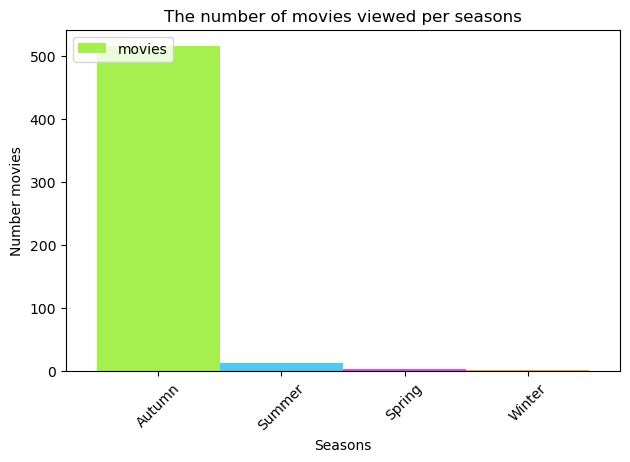

season
Autumn    516
Summer     13
Spring      4
Winter      2
Name: count, dtype: int64


In [39]:
# caluculate the number of show seen per seson
print("=> The number of shows viewed per seasons ")
counts = Traktdataset['season'].value_counts()
ax = counts.plot(title='' ,
            kind='bar', 
            color=['#A5F04F', '#4FC9F0', '#D950F0', '#F0A04F'],
            legend='views',
            width=1)

plt.title('The number of movies viewed per seasons')
plt.xlabel('Seasons')
plt.ylabel('Number movies')
plt.legend(['movies','movies','movies','movies'], loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()
print(counts)

=> The number of views by genre


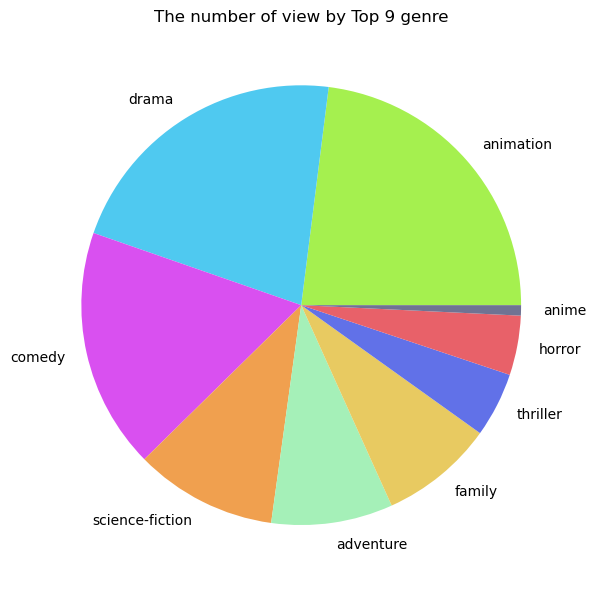

genre_film
animation          121
drama              114
comedy              93
science-fiction     55
adventure           47
family              44
thriller            25
horror              23
anime                4
Name: count, dtype: int64


In [40]:
# The number of movies viewed per seasons
print("=> The number of views by genre")
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
counts2 = Traktdataset['genre_film'].value_counts()
counts2[0:9].plot.pie(ax=ax1,colors=['#A5F04F', 
                                      '#4FC9F0', 
                                      '#D950F0', 
                                      '#F0A04F',
                                      '#A5F0B8',
                                      '#E8CA61',
                                      '#6171E8',
                                      '#E86169',
                                      '#6F7393',
                                      '#5C695F',
                                      '#719694'])

ax1.set_title('The number of view by Top 9 genre')
plt.tight_layout()
plt.xlabel("")
plt.ylabel("")

plt.show()
print(counts2[0:9])

=> The number of views by location 


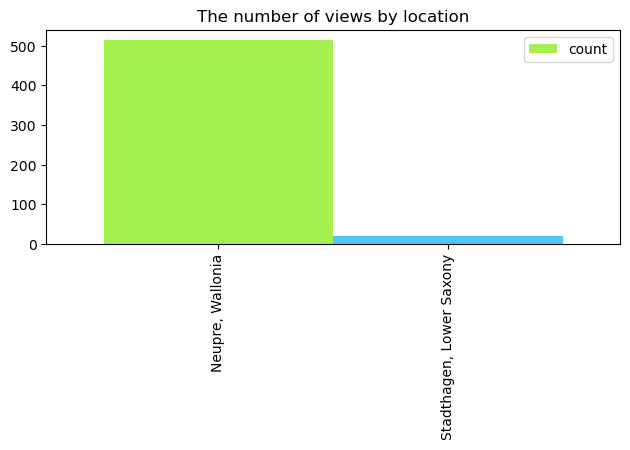

location
Neupre, Wallonia            514
Stadthagen, Lower Saxony     21
Name: count, dtype: int64


In [41]:
# number of views by location
print("=> The number of views by location ")
counts3 = Traktdataset['location'].value_counts()
ax = counts3.plot(title='' ,
            kind='bar', 
            color=['#A5F04F', '#4FC9F0', '#D950F0', '#F0A04F'],
            legend='views',
            width=1)
plt.title('The number of views by location')
plt.tight_layout()
plt.xlabel("")
plt.ylabel("")
plt.show()
print(counts3)

=> Spring genre 
genre_film
drama        2
thriller     1
animation    1
Name: count, dtype: int64


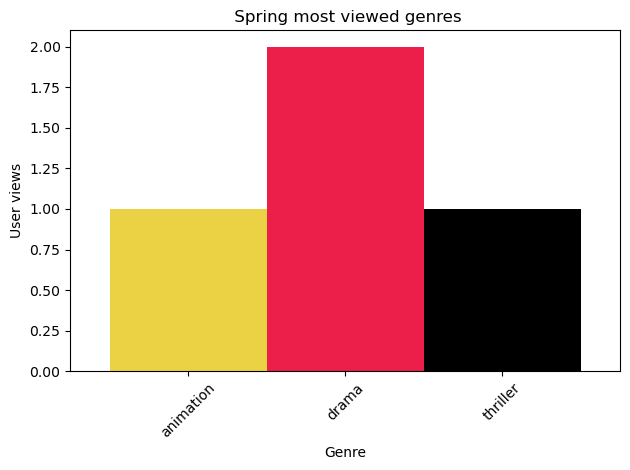

In [42]:
# Spring most viewed
try:
    print("=> Spring genre ")
    sprinDataSet = Traktdataset.loc[Traktdataset['season'] == 'Spring']
    springCounts = sprinDataSet['genre_film'].value_counts()
    print(springCounts[0:5])
    springCounts = springCounts[0:5].sort_index()
    
    ax = springCounts[0:5].plot(
                kind='bar', 
                color=['#EBD244', '#EB1F49', '#000000', '#29EACA', '#7F7862'],
                width=1)
    
    plt.title(' Spring most viewed genres')
    plt.xlabel('Genre')
    plt.ylabel('User views')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except:
    print("No Spring data")

=> Autumn genre 
genre_film
animation          118
drama              112
comedy              90
science-fiction     52
adventure           47
Name: count, dtype: int64


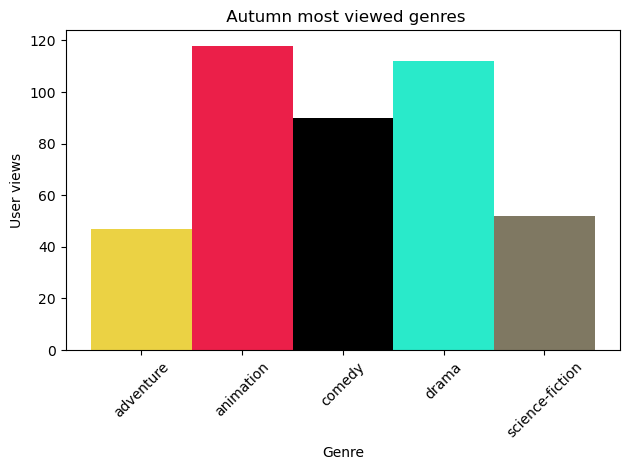

In [43]:
# Autumn most viewed
print("=> Autumn genre ")
try:
    AutumnDataSet = Traktdataset.loc[Traktdataset['season'] == 'Autumn']
    AutumnCounts = AutumnDataSet['genre_film'].value_counts()
    print(AutumnCounts[0:5])
    AutumnCounts = AutumnCounts[0:5].sort_index()
    
    ax = AutumnCounts[0:5].plot(title='' ,
                kind='bar', 
                color=['#EBD244', '#EB1F49', '#000000', '#29EACA', '#7F7862'],
                width=1)
    
    plt.title(' Autumn most viewed genres')
    plt.xlabel('Genre')
    plt.ylabel('User views')
    plt.xticks(rotation=45)
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
except:
    print("No autumn data")

=> Winter genre 
genre_film
science-fiction    1
thriller           1
Name: count, dtype: int64


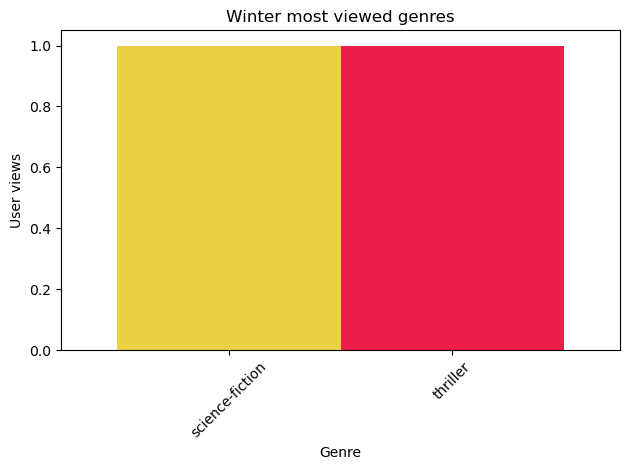

In [44]:
# Winter most viewed
print("=> Winter genre ")
try:
    WinterDataSet = Traktdataset.loc[Traktdataset['season'] == 'Winter']
    WinterCounts = WinterDataSet['genre_film'].value_counts()
    print(WinterCounts[0:5])
    WinterCounts = WinterCounts[0:5].sort_index()
    
    ax = WinterCounts[0:5].plot(title='' ,
                kind='bar', 
                color=['#EBD244', '#EB1F49', '#000000', '#29EACA', '#7F7862'],
                                width=1)
    
    plt.title('Winter most viewed genres')
    plt.xlabel('Genre')
    plt.ylabel('User views')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except:
    print("No winter data")

=> Summer genre 
genre_film
family             3
comedy             3
animation          2
science-fiction    2
horror             1
Name: count, dtype: int64


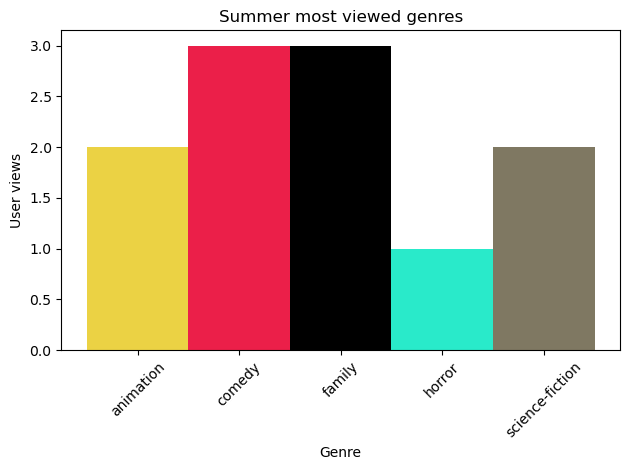

genre_film
animation          2
comedy             3
family             3
horror             1
science-fiction    2
Name: count, dtype: int64


In [45]:
# Summer most viewed
print("=> Summer genre ")
try:
    SummerDataSet = Traktdataset.loc[Traktdataset['season'] == 'Summer']
    SummerCounts = SummerDataSet['genre_film'].value_counts()
    print(SummerCounts[0:5])
    SummerCounts = SummerCounts[0:5].sort_index()
    
    ax = SummerCounts[0:5].plot(title='' ,
                kind='bar', 
                color=['#EBD244', '#EB1F49', '#000000', '#29EACA', '#7F7862'],
                width=1)
    
    plt.title('Summer most viewed genres')
    plt.xlabel('Genre')
    plt.ylabel('User views')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(SummerCounts[0:5])
except:
    print("No summer data")

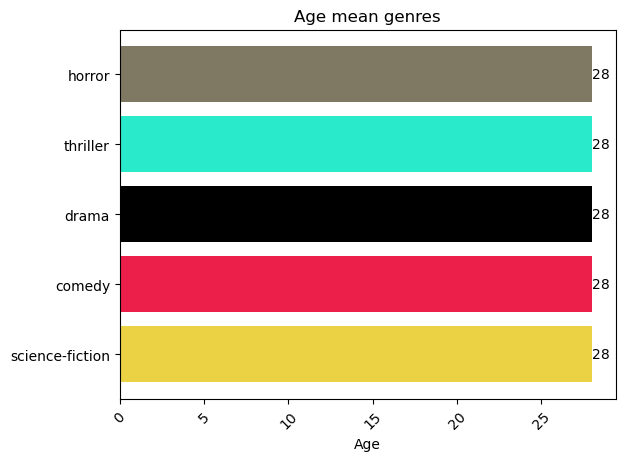

In [46]:
# Age Mean of Scifi viewers
ScifiDataSet = Traktdataset.loc[Traktdataset['genre_film'] == 'science-fiction']
mean1 = int(ScifiDataSet['age'].mean())
ComedyDataSet = Traktdataset.loc[Traktdataset['genre_film'] == 'comedy']
mean2 = int(ComedyDataSet['age'].mean())
DramaDataSet = Traktdataset.loc[Traktdataset['genre_film'] == 'drama']
mean3 = int(DramaDataSet['age'].mean())
thrillerDataSet = Traktdataset.loc[Traktdataset['genre_film'] == 'thriller']
mean4 = int(thrillerDataSet['age'].mean())
horrorDataSet = Traktdataset.loc[Traktdataset['genre_film'] == 'horror']
mean5 = int(horrorDataSet['age'].mean())

means = [mean1, mean2, mean3, mean4, mean5]
indexes = ['science-fiction', 'comedy', 'drama', 'thriller', 'horror']
colors = ['#EBD244', '#EB1F49', '#000000', '#29EACA', '#7F7862']

bars = plt.barh(indexes, means, label=indexes, color=colors)
plt.bar_label(bars)

    
plt.xlabel('Age')
plt.title('Age mean genres')
plt.xticks(rotation=45)
plt.show()